In [1]:
import sys

sys.path.append("..")

In [2]:
import pandas as pd

from src.transformers import *
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    BaggingRegressor,
)
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
train = pd.read_csv("../data/raw/train.csv")
test = pd.read_csv("../data/raw/test.csv")

## Outlier Detection

### Describing the numerical column

In [4]:
train.describe()[
    [
        "manufactured",
        "curb_weight",
        "power",
        "engine_cap",
        "depreciation",
        "coe",
        "road_tax",
        "dereg_value",
        "mileage",
        "omv",
        "arf",
    ]
]

,manufactured,curb_weight,power,engine_cap,depreciation,coe,road_tax,dereg_value,mileage,omv,arf
count,16590.000000,16205.000000,14447.000000,16731.000000,16351.000000,15893.000000,14630.000000,15595.000000,13060.000000,1.674300e+04,16500.000000
mean,2014.212417,1554.616230,133.950647,2086.423944,14489.055104,41336.704524,1358.951880,44208.937865,72539.375651,3.896792e+04,38636.758242
std,8.771572,820.442216,74.294299,1126.062034,19367.989982,16553.755676,1187.558721,42816.473242,50985.924208,4.445251e+04,59749.028200
min,1933.000000,2.000000,40.500000,0.000000,2680.000000,10.000000,50.000000,97.000000,1.000000,8.880000e+02,63.000000
25%,2011.000000,1280.000000,90.000000,1497.000000,8630.000000,31335.000000,684.000000,24985.000000,32661.500000,1.919300e+04,12614.250000
50%,2016.000000,1440.000000,110.000000,1797.000000,10610.000000,40512.000000,976.000000,35556.000000,65801.500000,2.708400e+04,21698.000000
75%,2018.000000,1680.000000,147.000000,2356.000000,14870.000000,51600.000000,1369.000000,50403.500000,104000.000000,4.068750e+04,42642.750000
max,2925.000000,20980.000000,552.000000,15681.000000,865610.000000,97889.000000,12375.000000,653862.000000,740459.000000,1.150000e+06,858230.000000


### Using Box-Plot to identify Outliers

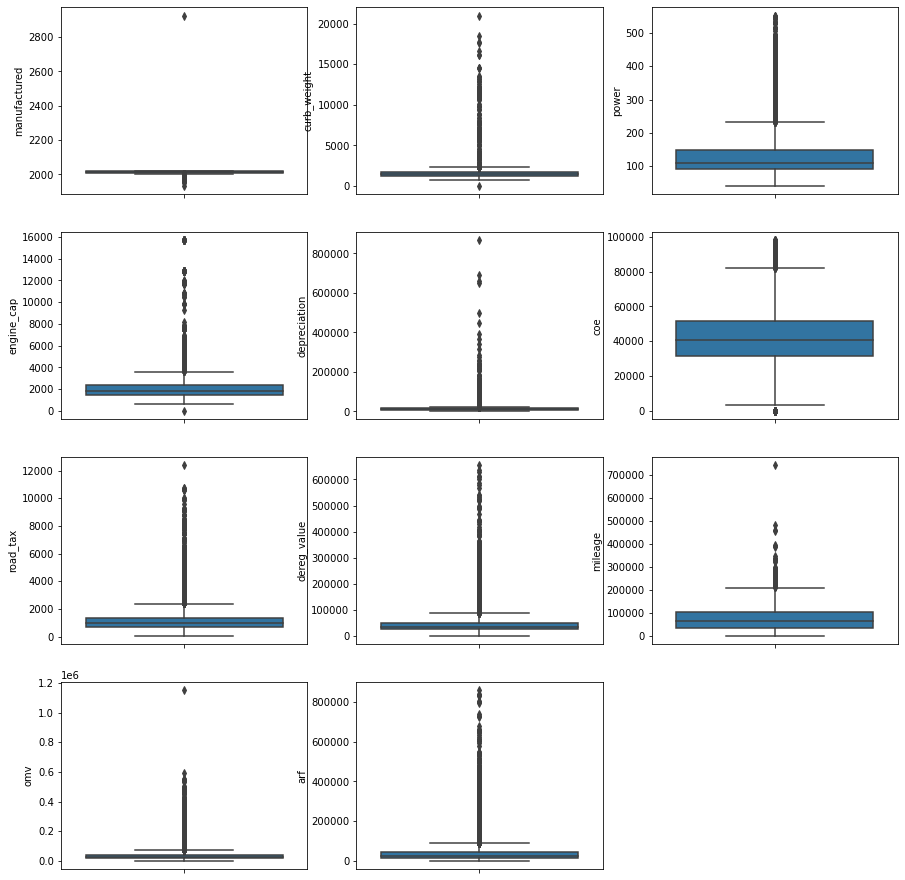

In [5]:
plt.figure(figsize=(15, 20))
numeric_cols = train.select_dtypes([np.number]).columns
cols = [
    "manufactured",
    "curb_weight",
    "power",
    "engine_cap",
    "depreciation",
    "coe",
    "road_tax",
    "arf",
    "price",
]
cols = [
    "manufactured",
    "curb_weight",
    "power",
    "engine_cap",
    "depreciation",
    "coe",
    "road_tax",
    "dereg_value",
    "mileage",
    "omv",
    "arf",
]
for i, col in enumerate(cols):
    plt.subplot(5, 3, i + 1)
    sns.boxplot(data=train, y=col)

<AxesSubplot:ylabel='coe'>

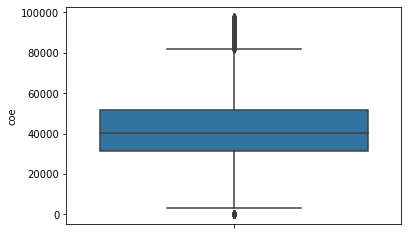

In [6]:
sns.boxplot(
    data=train, y="coe",
)

In [7]:
train[train.opc_scheme == "1100"][["listing_id", "title", "opc_scheme", "price"]]

,listing_id,title,opc_scheme,price
1749,1029091,Suzuki Swift 1.3M XG (OPC) (COE till 09/2023),1100,15200.0
12952,989043,Mazda 6 2.0A (OPC),1100,103300.0


<AxesSubplot:xlabel='opc_scheme', ylabel='Count'>

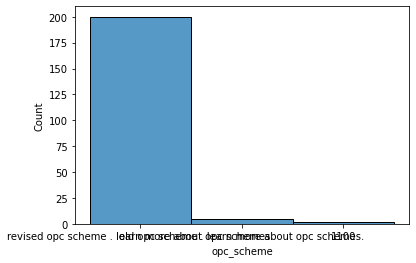

In [8]:
sns.histplot(data=train["opc_scheme"],)

### Observations

* Manufactured column contains values greater 2021, which can't be possible. It looks like data-entry error. A good intuitive way to handle this is to replace the value with OrigRegYear. That may give a close appromixation of the original value.

* Curb_weight: As shown in the table above and evident from box-plot, the column contains values less than 500 Kg. A car can't have weight this low. To handle such cases we will replace the values with the mode of similar make and model car.

* Mileage: Contains outliers, shown in box-blot. There are cars with mileage above 500000, where the median is 35000 and 98% of the cars are below 200000. To handle such cases we will replace the values with the mode of manufactured year.

* Engine_cap: There are cars with engine capacity as 0. This isn't possible, so to handle such cases we'll replace such values with cars of similar make and model

* Depreciation: For some cars depreciation is higher than the price itself. 

* COE: Outlier there in the data. The distribution graph seems off as well (chart below). Looking at the SgcarMart website, COE is represented in dollar value and in years. Need consistency. 


#### COE Dist plot

/Users/krishnakumar/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='coe', ylabel='Density'>

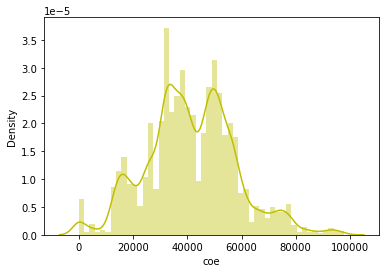

In [9]:
sns.distplot(train["coe"], color="y")

### EDA

Text(0.5, 1.0, 'Frequency of cars by type_of_vehicle')

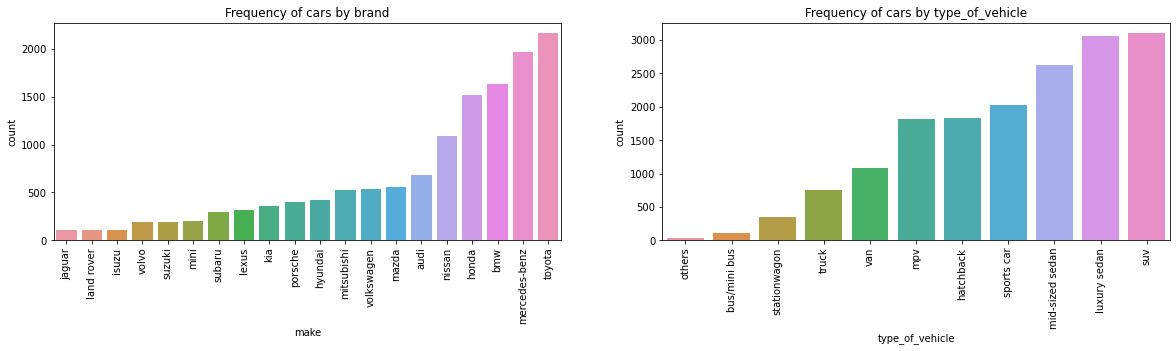

In [10]:
plt.figure(figsize=(20, 4))

temp = train.groupby("make").count()["model"].reset_index()
temp = temp[temp.model > 100].make.values
plt.subplot(1, 2, 1)
sns.countplot(
    x="make",
    data=train[train.make.isin(temp)],
    order=train[train.make.isin(temp)].make.value_counts(ascending=True).index,
)
plt.xticks(rotation=90)
plt.title("Frequency of cars by brand")

plt.subplot(1, 2, 2)
sns.countplot(
    x="type_of_vehicle",
    data=train,
    order=train.type_of_vehicle.value_counts(ascending=True).index,
)
plt.xticks(rotation=90)
plt.title("Frequency of cars by type_of_vehicle")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]),
 [Text(0, 0, 'saab'),
  Text(1, 0, 'seat'),
  Text(2, 0, 'volvo'),
  Text(3, 0, 'yutong'),
  Text(4, 0, 'mini'),
  Text(5, 0, 'scania'),
  Text(6, 0, 'ford'),
  Text(7, 0, 'austin'),
  Text(8, 0, 'mg'),
  Text(9, 0, 'daimler'),
  Text(10, 0, 'infiniti'),
  Text(11, 0, 'skoda'),
  Text(12, 0, 'audi'),
  Text(13, 0, 'lexus'),
  Text(14, 0, 'bmw'),
  Text(15, 0, 'hummer'),
  Text(16, 0, 'lotus'),
  Text(17, 0, 'alfa romeo'),
  Text(18, 0, 'jaguar'),
  Text(19, 0, 'mercedes-benz'),
  Text(20, 0, 'mercedes'),
  Text(21, 0, 'jeep'),
  Text(22, 0, 'land rover'),
  Text(23, 0, 'cupra'),
  Text(24, 0, 'mitsuoka'),
  Text(25, 0, 'maserati'),
  Text(26, 0, 'alpine'),
  Text(27, 0, 'porsche'),
  Text(28, 0, 'tesla'),
  Text(29, 0, 'aston martin'),
  Text(30, 0, 'bentley'),
  Text(31, 0, 'mclaren'),
  Text(32, 0, 'lamborghini'),
  

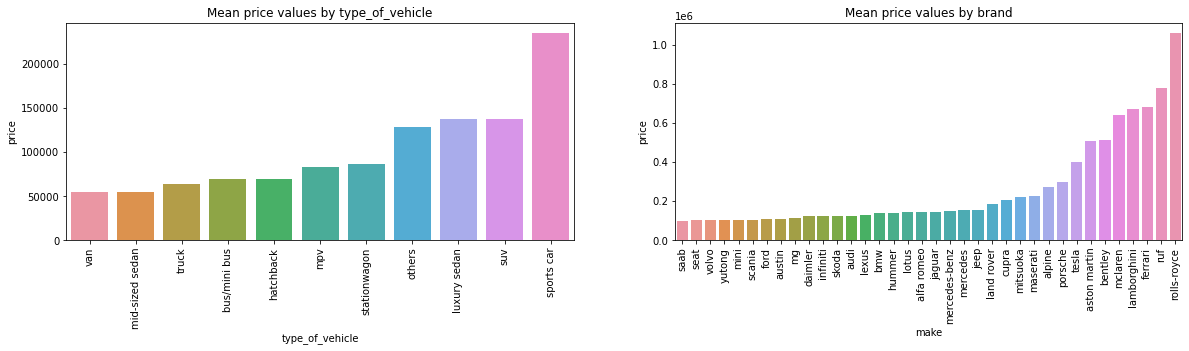

In [11]:
plt.figure(figsize=(20, 4))
df = train.groupby(["type_of_vehicle"]).mean().reset_index()
plt.subplot(1, 2, 1)
sns.barplot(data=df.sort_values(by=["price"]), x="type_of_vehicle", y="price")
plt.xticks(rotation=90)
plt.title("Mean price values by type_of_vehicle")

df = train.groupby(["make"]).mean().reset_index()
df = df[df["price"] > 100000]
plt.subplot(1, 2, 2)
sns.barplot(data=df.sort_values(by=["price"]), x="make", y="price")
plt.title("Mean price values by brand")
plt.xticks(rotation=90)

### Log Transformation of Mileage and COE Feature

/Users/krishnakumar/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/krishnakumar/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution with Log transformation')

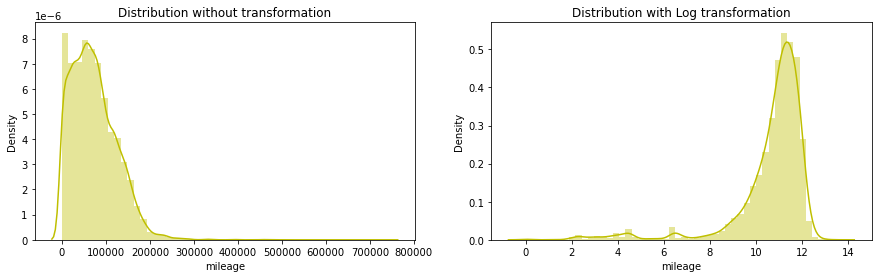

In [12]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
sns.distplot(train["mileage"], color="y")
plt.title("Distribution without transformation")

plt.subplot(1, 2, 2)
sns.distplot(np.log(train.mileage), color="y")
plt.title("Distribution with Log transformation")

/Users/krishnakumar/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/krishnakumar/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution with Log transformation')

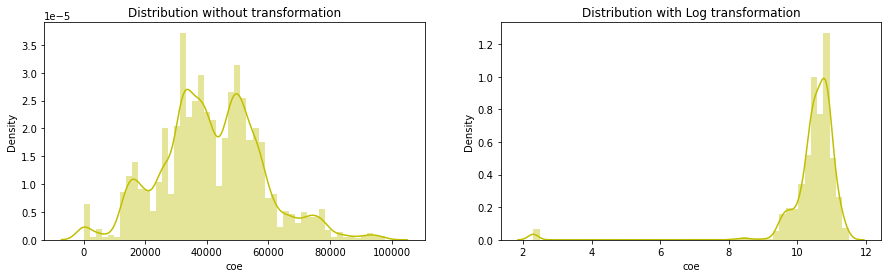

In [13]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
sns.distplot(train["coe"], color="y")
plt.title("Distribution without transformation")

plt.subplot(1, 2, 2)
sns.distplot(np.log(train.coe), color="y")
plt.title("Distribution with Log transformation")

### Observation:
Two distributions one at the start and other at the end. Clearly different formats -> Outliers.

### Bivariate Analysis

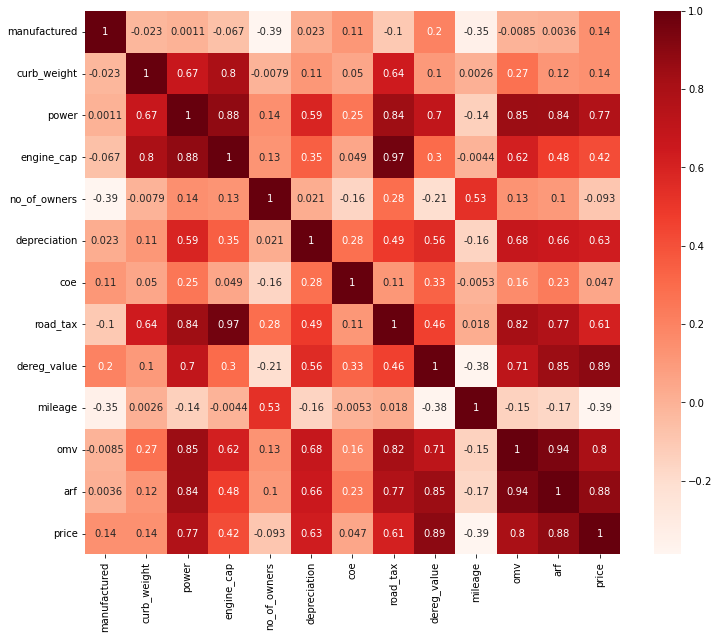

In [14]:
plt.figure(figsize=(12, 10))
cor = train.drop(["listing_id", "indicative_price"], axis=1).corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

<AxesSubplot:xlabel='price', ylabel='type_of_vehicle'>

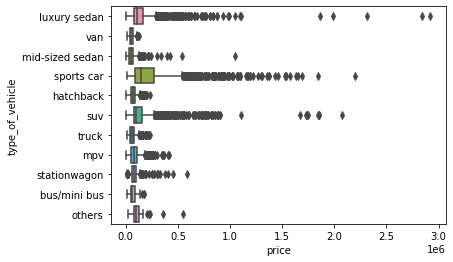

In [15]:
sns.boxplot(data=train, y="type_of_vehicle", x="price")

/Users/krishnakumar/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/krishnakumar/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mileage', ylabel='price'>

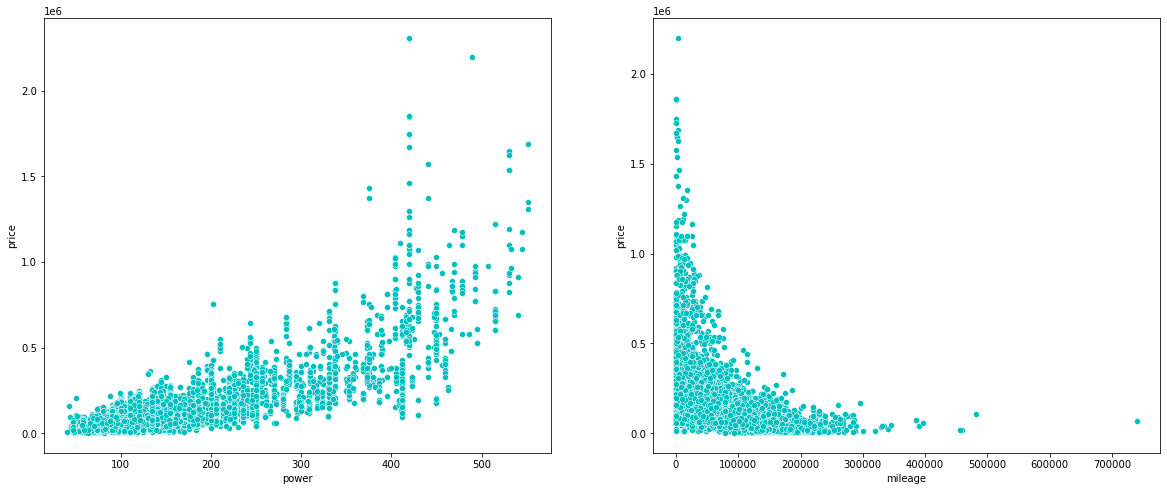

In [16]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.scatterplot(train.power, train.price, color=["c"])

plt.subplot(1, 2, 2)
sns.scatterplot((train.mileage), train["price"], color=["c"])

* Higher power higher price
* Higher mileage lower price generally

### Price feature 

/Users/krishnakumar/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


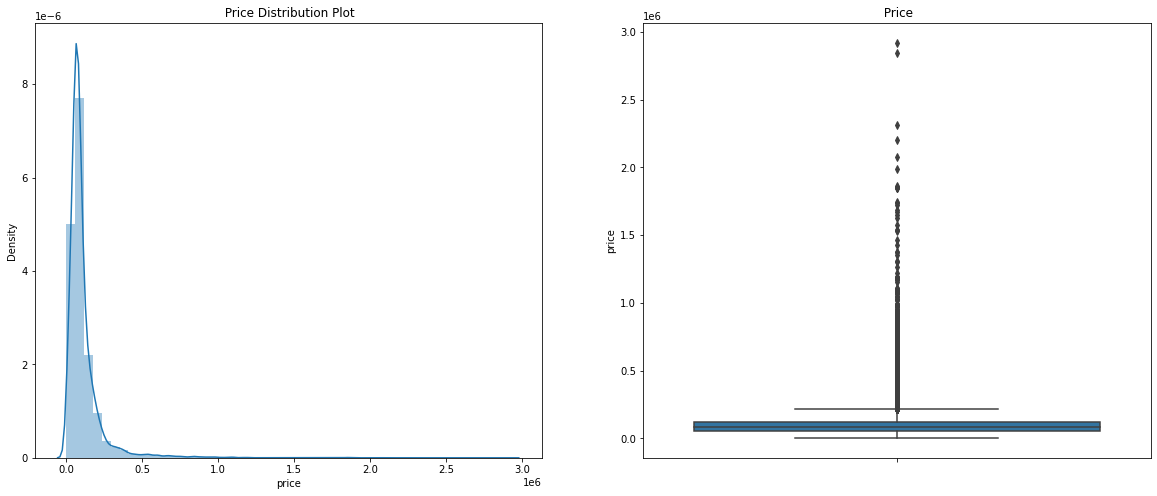

In [17]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title(" Price Distribution Plot")
sns.distplot(train.price)

plt.subplot(1, 2, 2)
plt.title(" Price")
sns.boxplot(y=train.price)

plt.show()

* There is a significant difference between the mean and the median of the price distribution.
* 90% of the prices are below 200K, whereas the remaining 10% are between 200K and 3000K.
* The distribution is positively skewed with the tail on the right side.